# Peter dan Serigala: Pengantar Pembelajaran Penguatan

Dalam tutorial ini, kita akan belajar bagaimana menerapkan pembelajaran penguatan pada masalah pencarian jalur. Pengaturan ini terinspirasi oleh kisah musikal [Peter dan Serigala](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) karya komposer Rusia [Sergei Prokofiev](https://en.wikipedia.org/wiki/Sergei_Prokofiev). Ini adalah cerita tentang seorang pelopor muda bernama Peter, yang dengan berani keluar dari rumahnya menuju hutan untuk mengejar serigala. Kita akan melatih algoritma pembelajaran mesin yang akan membantu Peter menjelajahi area sekitarnya dan membangun peta navigasi yang optimal.

Pertama, mari kita impor beberapa pustaka yang berguna:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Gambaran Umum Reinforcement Learning

**Reinforcement Learning** (RL) adalah teknik pembelajaran yang memungkinkan kita mempelajari perilaku optimal dari **agen** dalam suatu **lingkungan** dengan menjalankan banyak eksperimen. Agen dalam lingkungan ini harus memiliki **tujuan**, yang didefinisikan oleh **fungsi reward**.

## Lingkungan

Untuk menyederhanakan, mari kita anggap dunia Peter sebagai papan persegi berukuran `width` x `height`. Setiap sel di papan ini dapat berupa:
* **tanah**, tempat Peter dan makhluk lainnya dapat berjalan
* **air**, yang jelas tidak bisa dilalui
* **pohon** atau **rumput** - tempat di mana kamu bisa beristirahat
* **apel**, yang mewakili sesuatu yang Peter senang temukan untuk mengisi perutnya
* **serigala**, yang berbahaya dan harus dihindari

Untuk bekerja dengan lingkungan ini, kita akan mendefinisikan sebuah kelas bernama `Board`. Agar notebook ini tidak terlalu penuh, kita telah memindahkan semua kode untuk bekerja dengan papan ke dalam modul terpisah bernama `rlboard`, yang sekarang akan kita impor. Kamu dapat melihat isi modul ini untuk mendapatkan lebih banyak detail tentang implementasi internalnya.


In [2]:
from rlboard import *

Mari kita buat papan acak dan lihat bagaimana tampilannya:


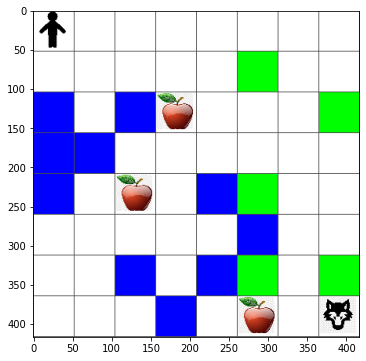

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Tindakan dan Kebijakan

Dalam contoh kita, tujuan Peter adalah menemukan sebuah apel, sambil menghindari serigala dan rintangan lainnya. Untuk mencapai ini, dia pada dasarnya bisa berjalan-jalan sampai menemukan apel. Oleh karena itu, di setiap posisi dia dapat memilih salah satu dari tindakan berikut: atas, bawah, kiri, dan kanan. Kita akan mendefinisikan tindakan-tindakan tersebut sebagai sebuah kamus, dan memetakan mereka ke pasangan perubahan koordinat yang sesuai. Sebagai contoh, bergerak ke kanan (`R`) akan sesuai dengan pasangan `(1,0)`.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

Strategi agen kita (Peter) didefinisikan oleh apa yang disebut sebagai **kebijakan**. Mari kita pertimbangkan kebijakan paling sederhana yang disebut **jalan acak**.

## Jalan acak

Mari kita selesaikan masalah kita terlebih dahulu dengan menerapkan strategi jalan acak.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Mari jalankan eksperimen random walk beberapa kali dan lihat rata-rata jumlah langkah yang diambil:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Fungsi Reward

Untuk membuat kebijakan kita lebih cerdas, kita perlu memahami langkah mana yang "lebih baik" dibandingkan yang lain.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-Learning

Buat sebuah Q-Table, atau array multi-dimensi. Karena papan kita memiliki dimensi `width` x `height`, kita dapat merepresentasikan Q-Table menggunakan array numpy dengan bentuk `width` x `height` x `len(actions)`:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Lewati Q-Table ke fungsi plot untuk memvisualisasikan tabel di papan:


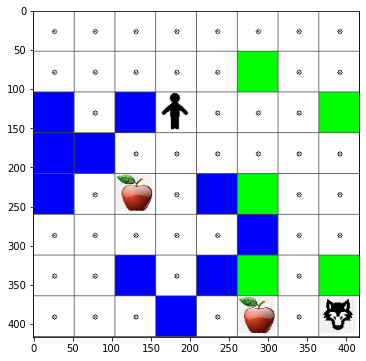

In [9]:
m.plot(Q)

## Esensi Q-Learning: Persamaan Bellman dan Algoritma Pembelajaran

Tulis pseudo-code untuk algoritma pembelajaran kita:

* Inisialisasi Q-Table Q dengan angka yang sama untuk semua keadaan dan aksi
* Tetapkan tingkat pembelajaran $\alpha\leftarrow 1$
* Ulangi simulasi berkali-kali
   1. Mulai dari posisi acak
   1. Ulangi
        1. Pilih aksi $a$ pada keadaan $s$
        2. Lakukan aksi dengan berpindah ke keadaan baru $s'$
        3. Jika kita menemui kondisi akhir permainan, atau total reward terlalu kecil - keluar dari simulasi  
        4. Hitung reward $r$ pada keadaan baru
        5. Perbarui Fungsi Q sesuai dengan persamaan Bellman: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Perbarui total reward dan kurangi $\alpha$.

## Eksploitasi vs. Eksplorasi

Pendekatan terbaik adalah menyeimbangkan antara eksplorasi dan eksploitasi. Saat kita semakin memahami lingkungan kita, kita akan lebih cenderung mengikuti jalur optimal, namun sesekali memilih jalur yang belum dijelajahi.

## Implementasi Python

Sekarang kita siap untuk mengimplementasikan algoritma pembelajaran. Sebelum itu, kita juga membutuhkan beberapa fungsi yang akan mengubah angka sembarang dalam Q-Table menjadi vektor probabilitas untuk aksi yang sesuai:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Kami menambahkan sejumlah kecil `eps` ke vektor asli untuk menghindari pembagian dengan 0 dalam kasus awal, ketika semua komponen vektor identik.

Algoritma pembelajaran yang sebenarnya akan dijalankan selama 5000 percobaan, yang juga disebut **epoch**:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

Setelah menjalankan algoritma ini, Q-Table harus diperbarui dengan nilai-nilai yang menentukan daya tarik dari berbagai tindakan pada setiap langkah. Visualisasikan tabel di sini:


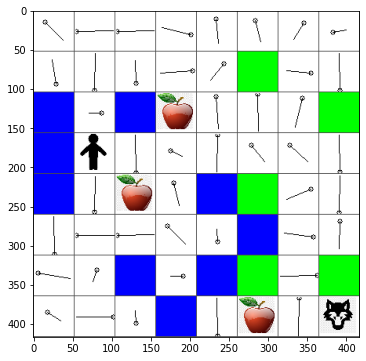

In [12]:
m.plot(Q)

## Memeriksa Kebijakan

Karena Q-Table mencantumkan "daya tarik" dari setiap tindakan di setiap keadaan, sangat mudah untuk menggunakannya untuk mendefinisikan navigasi yang efisien di dunia kita. Dalam kasus paling sederhana, kita hanya perlu memilih tindakan yang sesuai dengan nilai Q-Table tertinggi:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

Jika Anda mencoba kode di atas beberapa kali, Anda mungkin memperhatikan bahwa terkadang kode tersebut hanya "macet", dan Anda perlu menekan tombol STOP di notebook untuk menghentikannya.

> **Tugas 1:** Modifikasi fungsi `walk` untuk membatasi panjang maksimum jalur hingga sejumlah langkah tertentu (misalnya, 100), dan perhatikan kode di atas mengembalikan nilai ini dari waktu ke waktu.

> **Tugas 2:** Modifikasi fungsi `walk` agar tidak kembali ke tempat-tempat yang sudah pernah dikunjungi sebelumnya. Ini akan mencegah `walk` berputar-putar, namun agen masih bisa berakhir "terjebak" di lokasi yang tidak dapat ia tinggalkan.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


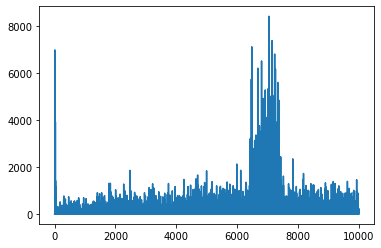

In [15]:
plt.plot(lpath)

Apa yang kita lihat di sini adalah bahwa pada awalnya rata-rata panjang jalur meningkat. Hal ini mungkin disebabkan oleh fakta bahwa ketika kita tidak tahu apa-apa tentang lingkungan - kita cenderung terjebak dalam keadaan buruk, seperti air atau serigala. Saat kita belajar lebih banyak dan mulai menggunakan pengetahuan ini, kita dapat menjelajahi lingkungan lebih lama, tetapi kita masih belum tahu dengan baik di mana apel berada.

Setelah kita belajar cukup banyak, menjadi lebih mudah bagi agen untuk mencapai tujuan, dan panjang jalur mulai berkurang. Namun, kita masih terbuka untuk eksplorasi, sehingga kita sering menyimpang dari jalur terbaik dan mencoba opsi baru, yang membuat jalur lebih panjang dari yang optimal.

Apa yang juga kita amati pada grafik ini adalah bahwa pada suatu titik panjang jalur meningkat secara tiba-tiba. Hal ini menunjukkan sifat stokastik dari proses tersebut, dan bahwa kita pada suatu saat dapat "merusak" koefisien Q-Table dengan menimpanya dengan nilai-nilai baru. Idealnya, hal ini harus diminimalkan dengan menurunkan tingkat pembelajaran (misalnya, menjelang akhir pelatihan kita hanya menyesuaikan nilai Q-Table dengan nilai kecil).

Secara keseluruhan, penting untuk diingat bahwa keberhasilan dan kualitas proses pembelajaran sangat bergantung pada parameter, seperti tingkat pembelajaran, penurunan tingkat pembelajaran, dan faktor diskon. Parameter-parameter ini sering disebut **hiperparameter**, untuk membedakannya dari **parameter** yang kita optimalkan selama pelatihan (misalnya, koefisien Q-Table). Proses menemukan nilai hiperparameter terbaik disebut **optimisasi hiperparameter**, dan ini layak menjadi topik tersendiri.


## Latihan
#### Dunia Peter dan Serigala yang Lebih Realistis

Dalam situasi kita, Peter dapat bergerak hampir tanpa merasa lelah atau lapar. Dalam dunia yang lebih realistis, dia harus duduk dan beristirahat dari waktu ke waktu, serta memberi makan dirinya sendiri. Mari kita buat dunia kita lebih realistis dengan menerapkan aturan-aturan berikut:

1. Dengan berpindah dari satu tempat ke tempat lain, Peter kehilangan **energi** dan mendapatkan sedikit **kelelahan**.
2. Peter dapat mendapatkan lebih banyak energi dengan memakan apel.
3. Peter dapat menghilangkan kelelahan dengan beristirahat di bawah pohon atau di atas rumput (yaitu berjalan ke lokasi papan yang memiliki pohon atau rumput - lapangan hijau).
4. Peter perlu menemukan dan membunuh serigala.
5. Untuk membunuh serigala, Peter harus memiliki tingkat energi dan kelelahan tertentu, jika tidak, dia akan kalah dalam pertempuran.

Modifikasi fungsi reward di atas sesuai dengan aturan permainan, jalankan algoritma pembelajaran penguatan untuk mempelajari strategi terbaik dalam memenangkan permainan, dan bandingkan hasilnya antara jalan acak dengan algoritma Anda dalam hal jumlah permainan yang dimenangkan dan kalah.

> **Note**: Anda mungkin perlu menyesuaikan hiperparameter agar berhasil, terutama jumlah epoch. Karena keberhasilan permainan (melawan serigala) adalah peristiwa yang jarang terjadi, Anda dapat mengharapkan waktu pelatihan yang jauh lebih lama.



---

**Penafian**:  
Dokumen ini telah diterjemahkan menggunakan layanan terjemahan AI [Co-op Translator](https://github.com/Azure/co-op-translator). Meskipun kami berupaya untuk memberikan hasil yang akurat, harap diperhatikan bahwa terjemahan otomatis mungkin mengandung kesalahan atau ketidakakuratan. Dokumen asli dalam bahasa aslinya harus dianggap sebagai sumber yang berwenang. Untuk informasi yang bersifat kritis, disarankan menggunakan jasa terjemahan manusia profesional. Kami tidak bertanggung jawab atas kesalahpahaman atau penafsiran yang keliru yang timbul dari penggunaan terjemahan ini.
